In [5]:
import json
import os
import subprocess
import glob

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json
import copy

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit

import ast

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm

import uproot 


In [2]:
! ls ./Data

MD_LS_energy1000_scan1.h5  MD_LS_energy5000_scan1.h5  MD_LS_sim3000.h5
MD_LS_energy3000_scan2.h5  MD_LS_sim1000.h5	      MD_LS_sim5000.h5


In [3]:



beta_CRY =  202.14283989353822
alpha_CRY = -3.542768392822383

beta_COLL =   151.98832189100114
alpha_COLL =  1.5212968243622182

deltaphi_CRY_COLL = 0.3320954889610304

CO_TCP = -5.424275667608168e-07
beta_TCP = 140.75752795686023

In [4]:
def erfunc(x,a,b,c,d):
	return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

def calc_emittance(energy):
	mp = 0.9382
	emittance_n = 3.5e-6
	gamma = energy/mp
	beta = np.sqrt(1-1/(gamma*gamma))
	return emittance_n/(beta*gamma)

# data


In [5]:
datafile_1000 = "./Data/MD_LS_energy1000_scan1.h5"
sim_file_1000 = "./Data/MD_LS_sim1000.h5"
datafile_3000 = "./Data/MD_LS_energy3000_scan2.h5"
sim_file_3000 = "./Data/MD_LS_sim3000.h5"
datafile_5000 = "./Data/MD_LS_energy5000_scan1.h5"
sim_file_5000 = "./Data/MD_LS_sim5000.h5"

In [6]:
LSdata_data_1000 = pd.read_hdf(datafile_1000, key='LSdata') 
LSsim_data_1000 = pd.read_hdf(sim_file_1000, key='LSdata')
metadata_data_1000 = pd.read_hdf(datafile_1000, key='metadata')
metadata_sim_1000 = pd.read_hdf(sim_file_1000, key='metadata')

LSdata_data_3000 = pd.read_hdf(datafile_3000, key='LSdata') 
LSsim_data_3000 = pd.read_hdf(sim_file_3000, key='LSdata')
metadata_data_3000 = pd.read_hdf(datafile_3000, key='metadata')
metadata_sim_3000 = pd.read_hdf(sim_file_3000, key='metadata')


LSdata_data_5000 = pd.read_hdf(datafile_5000, key='LSdata') 
LSsim_data_5000 = pd.read_hdf(sim_file_5000, key='LSdata')
metadata_data_5000 = pd.read_hdf(datafile_5000, key='metadata')
metadata_sim_5000 = pd.read_hdf(sim_file_5000, key='metadata')

In [7]:
def linscan_data(LSdata_data, metadata_data):

    fig, ax = plt.subplots(figsize=(10,5))	


    params = metadata_data['param0'].iloc[0], metadata_data['param1'].iloc[0], metadata_data['param2'].iloc[0], metadata_data['param3'].iloc[0]

    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')

    # distance between centre of channeled beam and primary beam envelope
    deltax = metadata_data['deltax'].iloc[0]
    PosEnvelope = metadata_data['PosEnvelope'].iloc[0]
    RangetoMeanEnv = metadata_data['RangetoMeanEnv_min'].iloc[0], metadata_data['RangetoMeanEnv_max'].iloc[0]

    theta_calc = metadata_data['theta_calc'].iloc[0] #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))

    #ax.plot(LSdata_data.CollPos, abs(params[1])*norm.pdf(LSdata_data.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')
    #ax.errorbar(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, yerr=LSdata_data.BLM_Coll_Err_norm, label='Data', marker='o', markersize=5)
    ax.plot(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, label='Data', marker='o', markersize=5)
    ax.plot(LSdata_data.CollPos, erfunc(LSdata_data.CollPos, *params), label='Fit', zorder=10)

    #ax.plot(LSdata_data.CollPos, m * LSdata_data.CollPos + q, color='green', label='Channeled beam profile')

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    ax.set_ylabel('BLM signal (flux-normalized) [a.u.]', fontsize=12)

    ax.hlines(y=1, xmin=PosEnvelope-RangetoMeanEnv[0], xmax=PosEnvelope+RangetoMeanEnv[1], linewidth=2, color='k', linestyles='--')

    ax2 = ax.twiny()
    ax2.plot(LSdata_data.CollPos_thetaframe, LSdata_data.BLM_Coll_norm, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)


    # ax.get_yaxis().set_visible(False)
    ax.set_ylim(0,2.5)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    # ax.yaxis.grid(False)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    lines1, labels1 = ax.get_legend_handles_labels()
    plt.legend(lines1, labels1, fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    ax2.axvline(0, color='grey', linestyle='--')

    #ax.axvline(PosMaxErfFit, color='r', linestyle='--')

    #ax.set_title(f'B2H LINEAR SCAN     Energy: {energy} GeV', fontsize=14)


In [8]:
def linscan_sim(LSsim_data, metadata_sim):
    
    beta_CRY = metadata_sim['beta_CRY'].iloc[0] 
    beta_COLL = metadata_sim['beta_COLL'].iloc[0]
    deltaphi_CRY_COLL = metadata_sim['deltaphi_CRY_COLL'].iloc[0]
    PosEnvelope = metadata_sim['PosEnvelope'].iloc[0] 
    PosMaxErfFit = metadata_sim['PosMaxErfFit'].iloc[0]   
    normalize = metadata_sim['normal'].iloc[0]
   

    def erfunc(x,a,b,c,d):
        return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))

    params = metadata_sim['param0'].iloc[0], metadata_sim['param1'].iloc[0], metadata_sim['param2'].iloc[0], metadata_sim['param3'].iloc[0] # extras = opt.curve_fit(erfunc, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].CollPos, self.LSdata[self.LSdata['CollPos'] > PosMaxErfFit].Counts, p0=param0)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(LSsim_data.CollPos, LSsim_data.Counts)
    #ax.plot(LSdata.CollPos, erfunc(LSdata.CollPos, param0[0], param0[1], param0[2], param0[3]))
    ax.plot(LSsim_data.CollPos, erfunc(LSsim_data.CollPos, params[0], params[1], params[2], params[3]))
    ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e3:.{2}f}" for x_tick in ax.get_xticks()])
    ax.axvline(PosMaxErfFit, color='r', linestyle='--')
    ax.axvline(PosEnvelope, color='g', linestyle='--')
    ax.axhline(1, color='b', linestyle='--')


    print('Height: ', abs(params[1]), ' a.u.')
    print('Mean: ', params[2], ' mm')
    print('Sigma: ', abs(params[3]), ' mm')


    # distance between centre of channeled beam and primary beam envelope
    deltax = (abs(params[2])-abs(PosEnvelope))

    theta_calc = metadata_sim['theta_calc'].iloc[0] # (deltax-self.n_sigma*np.sqrt(self.emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
    print('Calculated theta [urad]: ', round(theta_calc*1.0e6,3))



    ax2 = ax.twiny()
    ax2.plot(LSsim_data.CollPos_thetaframe, LSsim_data.Counts, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)
    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    #ax.plot(self.LSdata.CollPos, 0.0001*abs(params[1])*norm.pdf(self.LSdata.CollPos,params[2],abs(params[3])), label='Channeled profile', color='green')

    efficiency = round(abs(params[1])*100,2)
    print('Efficiency: ', efficiency, '%')
    textstr = 'Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.8, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    return ax



In [82]:
def linscan_merge(LSdata_data, metadata_data, LSsim_data_orig, metadata_sim, new_fit = False, param0=None, PosMaxErfFit = None, PosEnvelope= None, energy = 450, savefig = False, plot_lines= True):

    fig, ax = plt.subplots(figsize=(10,5))	
    LSsim_data = copy.deepcopy(LSsim_data_orig)
    LSsim_data.CollPos = LSsim_data.CollPos*1e3

    PosEnvelope_sim = metadata_sim['PosEnvelope'].iloc[0]  *1e3

 
    TCP_LU =  metadata_data['TCP_LU'].iloc[0]
    TCP_RU = metadata_data['TCP_RU'].iloc[0]

    emittance = calc_emittance(energy)
    sigma_TCP = np.sqrt(emittance*beta_TCP)
    hgap = (TCP_LU-TCP_RU)/2
    n_sigma = hgap/sigma_TCP



    if new_fit:
        df_tofit = LSdata_data[LSdata_data['CollPos'] > PosMaxErfFit]
        params, extras = opt.curve_fit(erfunc, df_tofit.CollPos, df_tofit.BLM_Coll_norm, p0=param0, sigma=df_tofit.BLM_Coll_Err_norm)
        
        print('Height: ', abs(params[1]), ' a.u.')
        print('Mean: ', params[2], ' mm')
        print('Sigma: ', abs(params[3]), ' mm')

        # distance between centre of channeled beam and primary beam envelope
        deltax = (abs(params[2])-abs(PosEnvelope))*1.0e-3
        theta_calc = (deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
        print('New Theta: ', theta_calc)
    else:
        # distance between centre of channeled beam and primary beam envelope
        deltax = metadata_data['deltax'].iloc[0]
        params = metadata_data['param0'].iloc[0], metadata_data['param1'].iloc[0], metadata_data['param2'].iloc[0], metadata_data['param3'].iloc[0]
        PosEnvelope = metadata_data['PosEnvelope'].iloc[0]
        theta_calc = metadata_data['theta_calc'].iloc[0]
    RangetoMeanEnv = metadata_data['RangetoMeanEnv_min'].iloc[0], metadata_data['RangetoMeanEnv_max'].iloc[0]
     #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))
  

    params_sim = metadata_sim['param0'].iloc[0], metadata_sim['param1'].iloc[0], metadata_sim['param2'].iloc[0], metadata_sim['param3'].iloc[0]
    theta_calc_sim = metadata_sim['theta_calc'].iloc[0] #(deltax-n_sigma*np.sqrt(emittance*beta_COLL)*(np.cos(deltaphi_CRY_COLL)-1))/(np.sqrt(beta_CRY*beta_COLL)*np.sin(deltaphi_CRY_COLL))


    #denv =    PosEnvelope_sim -PosEnvelope
    denv = (TCP_LU - abs(TCP_RU))/2*1e3
    print('denv: ', denv)
    LSsim_data.CollPos = LSsim_data.CollPos - denv


 
    ax.plot(LSdata_data.CollPos, LSdata_data.BLM_Coll_norm, label='Data', marker='o', markersize=5)
    ax.plot(LSdata_data.CollPos, erfunc(LSdata_data.CollPos, *params), label='Fit Data', zorder=10)

    #ax.plot(LSdata_data.CollPos, m * LSdata_data.CollPos + q, color='green', label='Channeled beam profile')

    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_xlabel('Linear Transverse Position [mm]', fontsize=12)
    ax.set_ylabel('BLM signal (flux-normalized) [a.u.]', fontsize=12)

    ax.hlines(y=1, xmin=PosEnvelope-RangetoMeanEnv[0], xmax=PosEnvelope+RangetoMeanEnv[1], linewidth=2, color='k', linestyles='--')

    ax2 = ax.twiny()
    ax2.plot(LSdata_data.CollPos_thetaframe, LSdata_data.BLM_Coll_norm, alpha=0.0, color='k')
    ticks = ax2.get_xticks()
    ax2.xaxis.set_major_locator(FixedLocator(ticks))
    ax2.set_xticklabels([int(abs(tick)) for tick in ticks])
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_xlabel('Deflection angle [$\mu$rad]', fontsize=12)


    # ax.get_yaxis().set_visible(False)
    ax.set_ylim(0,2.5)
    ax.set_xlim(0.0, 10)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    # ax.yaxis.grid(False)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    lines1, labels1 = ax.get_legend_handles_labels()
    plt.legend(lines1, labels1, fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)


    textstr = 'DATA Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc*1.0e6,3),round(abs(params[1])*100,2),)+'%'
    textstr_sim = '\nSIM Bending angle: %.2f $\mu$rad\nEfficiency: %.2f' % (round(theta_calc_sim*1.0e6,3),round(abs(params_sim[1])*100,2),)+'%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.4, 0.6, textstr+textstr_sim, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)


    ax2.axvline(0, color='grey', linestyle='--')

    ax.plot(LSsim_data.CollPos, LSsim_data.Counts, label='Sim')
    if plot_lines:
        ax.axvline(PosEnvelope_sim - denv, color='r', linestyle='--')
        ax.axvline(PosEnvelope, color='g', linestyle='--')
    #ax.axvline(PosMaxErfFit, color='r', linestyle='--')

    ax.set_title(f'B2H LINEAR SCAN     Energy: {energy} GeV', fontsize=14)
    if savefig:
        plt.savefig(f'./Data/LS_merge_{energy}.png')
    return ax


# 1000 GeV

Height:  0.8730173668769929  a.u.
Mean:  0.006939690858775296  mm
Sigma:  0.0001717598709508704  mm
Calculated theta [urad]:  49.622
Efficiency:  87.3 %


(0.0, 2.5)

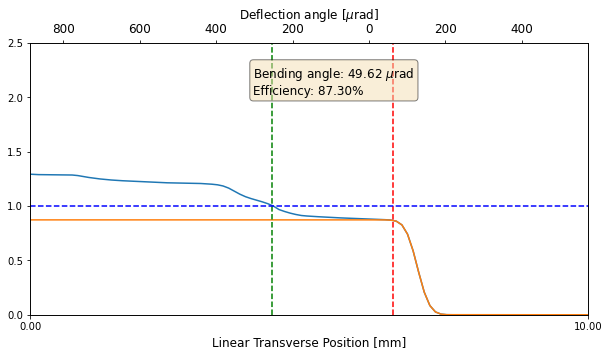

In [83]:
ax = linscan_sim(LSsim_data_1000, metadata_sim_1000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height:  0.8237421259521482  a.u.
Mean:  6.4055452620947975  mm
Sigma:  0.2347543992751272  mm
Calculated theta [urad]:  50.248


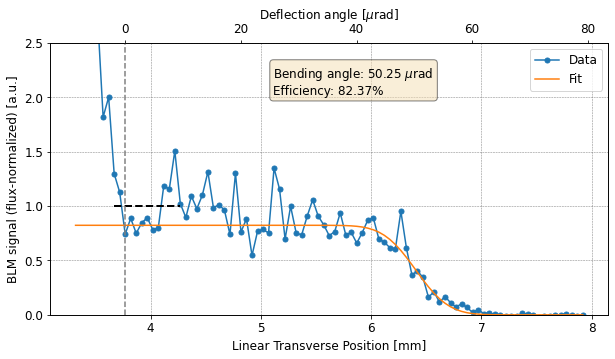

In [84]:
linscan_data(LSdata_data_1000, metadata_data_1000)

denv:  0.5599999999999997


(3.0, 9.0)

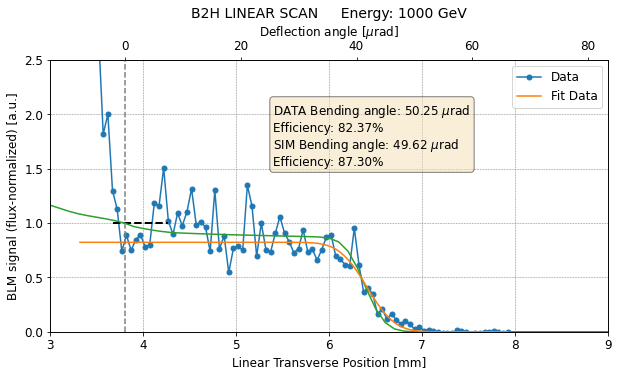

In [87]:
ax = linscan_merge(LSdata_data_1000, metadata_data_1000, LSsim_data_1000, metadata_sim_1000, energy=1000, plot_lines=False)
ax.set_xlim(3, 9)

Height:  0.90726714855419  a.u.
Mean:  6.36752692546116  mm
Sigma:  0.26766339435247016  mm
New Theta:  4.958248323540005e-05
denv:  0.5599999999999997


(3.0, 9.0)

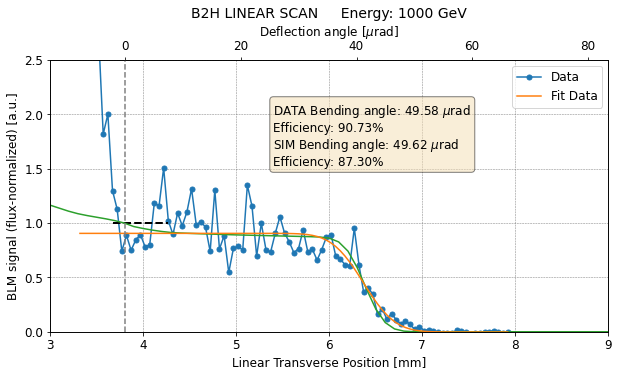

In [88]:
ax = linscan_merge(LSdata_data_1000, metadata_data_1000, LSsim_data_1000, metadata_sim_1000, new_fit=True, param0=[0.5,-0.9,6.5,0.2], PosMaxErfFit=5.8, PosEnvelope=3.77, energy=1000, plot_lines=False)
ax.set_xlim(3, 9)

In [71]:
metadata_data_1000

,param0,param1,param2,param3,PosMaxErfFit,PosEnvelope,RangetoMeanEnv_min,RangetoMeanEnv_max,normal,normal_err,theta_calc,deltax,TCP_LU,TCP_RU
0,0.411381,-0.823742,6.405545,0.234754,5.5,3.77,0.1,0.5,3.134632e-12,7.502884e-13,0.00005,0.002636,0.004715,-0.003595


In [49]:
metadata_sim_1000

,param0,param1,param2,param3,PosMaxErfFit,PosEnvelope,normal,theta_calc,deltax,beta_CRY,beta_COLL,deltaphi_CRY_COLL
0,0.436556,-0.873017,0.00694,0.000172,0.0065,0.00434,1.0,0.00005,0.0026,202.142863,151.988264,0.332096


In [29]:
TCP_LU =  2.86e-3
TCP_RU = -1.88e-3 

(TCP_LU - abs(TCP_RU))/2*1E3

0.4900000000000001

# 3000 GeV

Height:  0.8286662224942495  a.u.
Mean:  0.005175003509387147  mm
Sigma:  9.421127749586289e-05  mm
Calculated theta [urad]:  49.59
Efficiency:  82.87 %


(0.0, 2.5)

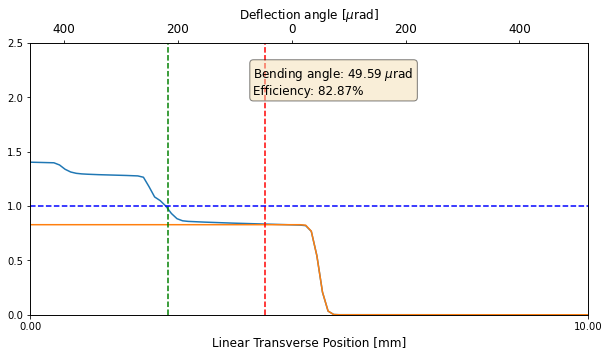

In [35]:
ax = linscan_sim(LSsim_data_3000, metadata_sim_3000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height: 

 0.6175904995957343  a.u.
Mean:  4.897564590133499  mm
Sigma:  0.2098949438543342  mm
Calculated theta [urad]:  50.085


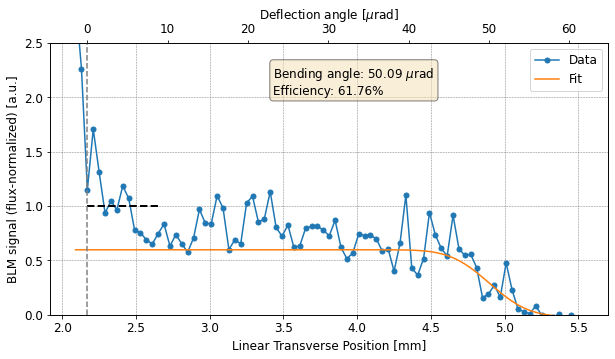

In [36]:
linscan_data(LSdata_data_3000, metadata_data_3000)

denv:  0.4900000000000001


(0.0, 3.0)

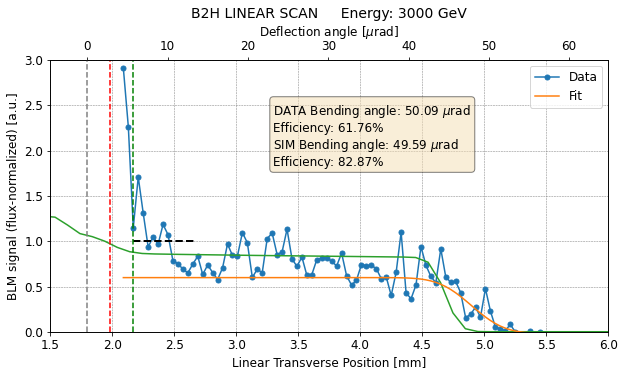

In [44]:
ax = linscan_merge(LSdata_data_3000, metadata_data_3000, LSsim_data_3000, metadata_sim_3000, energy = 3000)
ax.set_xlim(1.5, 6)
ax.set_ylim(0,3.0)

Height:  0.6405919746567901  a.u.
Mean:  4.887633470056417  mm
Sigma:  0.21872564713805062  mm
New Theta:  4.81608605580929e-05
denv:  0.4900000000000001


(0.0, 3.0)

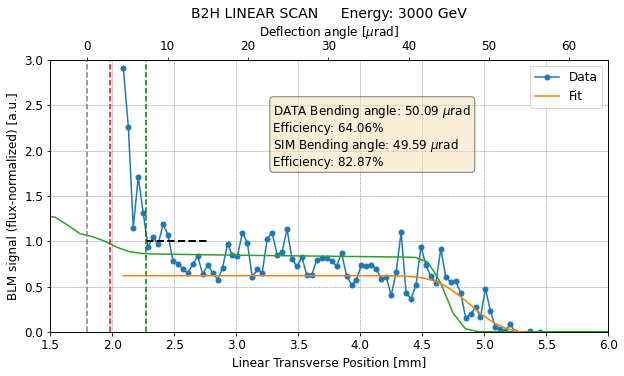

In [38]:
ax = linscan_merge(LSdata_data_3000, metadata_data_3000, LSsim_data_3000, metadata_sim_3000, new_fit=True, param0=[0.4, -0.61, 4.5, 0.21], PosMaxErfFit=3.5, PosEnvelope=2.27, energy = 3000)
ax.set_xlim(1.5, 6)
ax.set_ylim(0,3.0)

In [107]:
metadata_data_3000

,param0,param1,param2,param3,PosMaxErfFit,PosEnvelope,RangetoMeanEnv_min,RangetoMeanEnv_max,normal,normal_err,theta_calc,deltax,TCP_LU,TCP_RU
0,0.289241,-0.61759,4.897565,0.209895,3.7,2.17,0,0.5,7.096747e-12,2.106148e-12,0.00005,0.002728,0.00286,-0.00188


# 5000 GeV

Height:  0.8115865913268562  a.u.
Mean:  0.004654539715295892  mm
Sigma:  6.780073026049329e-05  mm
Calculated theta [urad]:  49.598
Efficiency:  81.16 %


(0.0, 2.5)

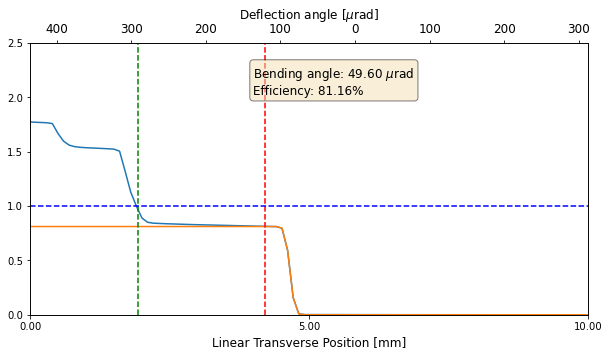

In [39]:
ax = linscan_sim(LSsim_data_5000, metadata_sim_5000)
ax.set_xlim(0.0, 0.01)
ax.set_ylim(0,2.5)

Height:  0.4650799026811937  a.u.
Mean:  4.4737791481430005  mm
Sigma:  0.062073991572250936  mm
Calculated theta [urad]:  52.819


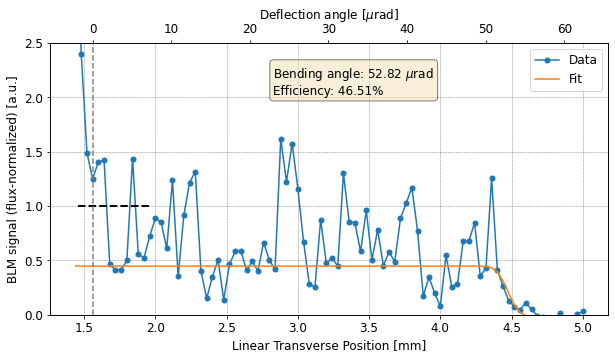

In [40]:
linscan_data(LSdata_data_5000, metadata_data_5000)

denv:  0.4475


(1.0, 5.5)

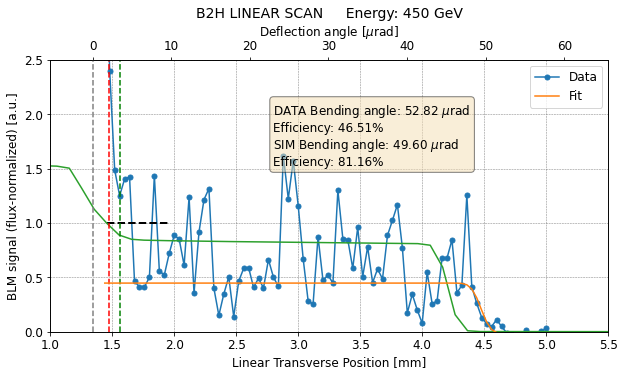

In [41]:
ax = linscan_merge(LSdata_data_5000, metadata_data_5000, LSsim_data_5000, metadata_sim_5000)
ax.set_xlim(1, 5.5)


# ANG SCAN

In [47]:
def plot_angular_scan(data_dict, cry_name = 'CRY', normalize = False):
    fig, ax = plt.subplots(figsize=(10, 5))
    data_dict = data_dict.set_index('index').T.to_dict() if isinstance(data_dict, pd.DataFrame) else data_dict
    n_cry_abs = []
    angles = []
    norm_abs = []
    for key in data_dict.keys():
        n_cry_abs.append(data_dict[key][cry_name+'_abs'])
        angles.append(data_dict[key]['angle'])
        norm_abs.append(data_dict[key][cry_name+'_abs'] / (data_dict[key]['npart'] ))

    if normalize:
        ax.plot(angles, norm_abs, marker='o')
    else:
        ax.plot(angles, n_cry_abs, marker='o')
    ax.set_xlabel('Angle [rad]', fontsize=12)
    ax.set_ylabel('Absorbed particles', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax2 = ax.twiny()
    ax2.plot(data_dict.keys(), norm_abs, alpha=0.0, color='k')
    #ax.set_yscale('log')
    return fig, ax, ax2

(<Figure size 720x360 with 2 Axes>,
 <Axes: xlabel='Angle [rad]', ylabel='Absorbed particles'>,
 <Axes: >)

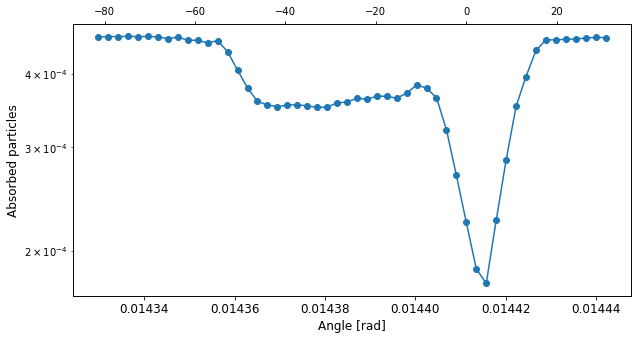

In [43]:
plot_angular_scan(pd.read_hdf('./Plots/CRY_ang_scan_1TeV.h5'), normalize=True)

In [36]:
df = pd.read_hdf('./Plots/CRY_ang_scan_1TeV.h5')

In [37]:
df["CRY_abs2"] = df["CRY_abs"]
df["CRY_abs"] = df["CRY_abs"]/df["npart"]



In [38]:
df["angle2"] = df["angle"]
df["angle"] = -df["angle"]


In [39]:
mean_amorph = np.mean(df[((df['index']>-81.5)& (df['index']<-66.0)) | ((df['index']>4.4)& (df['index']<31.0)) ]['CRY_abs'])
mean_std = np.std(df[((df['index']>-81.5)& (df['index']<-66.0)) | ((df['index']>4.4)& (df['index']<31.0)) ]['CRY_abs'])
df["CRY_abs"] = df["CRY_abs"]/mean_amorph


In [46]:
df

,index,CRY_abs,angle,align_angle,npart,CRY_abs2,angle2
0,-81.4,1.078466,-0.014330,0.000006,5000000.0,2317.0,0.014330
1,-79.2,1.079397,-0.014332,0.000008,5000000.0,2319.0,0.014332
2,-77.0,1.079397,-0.014334,0.000010,5000000.0,2319.0,0.014334
3,-74.8,1.080328,-0.014336,0.000012,5000000.0,2321.0,0.014336
4,-72.6,1.079397,-0.014339,0.000015,5000000.0,2319.0,0.014339
5,-70.4,1.079863,-0.014341,0.000017,5000000.0,2320.0,0.014341
6,-68.2,1.078001,-0.014343,0.000019,5000000.0,2316.0,0.014343
7,-66.0,1.070554,-0.014345,0.000021,5000000.0,2300.0,0.014345
8,-63.8,1.077070,-0.014347,0.000023,5000000.0,2314.0,0.014347
9,-61.6,1.064503,-0.014350,0.000026,5000000.0,2287.0,0.014350


In [45]:
mean_amorph

0.00042968421052631584

(<Figure size 720x360 with 2 Axes>,
 <Axes: xlabel='Angle [rad]', ylabel='Absorbed particles'>,
 <Axes: >)

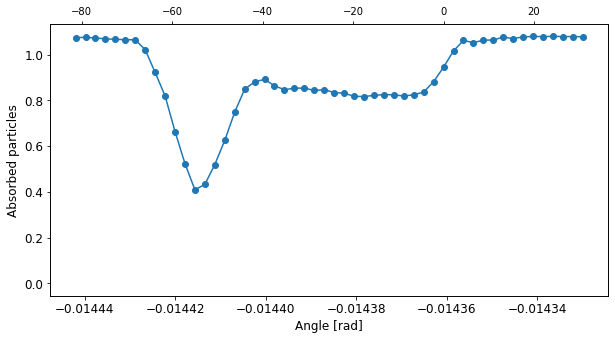

In [48]:
plot_angular_scan(df)

In [25]:
mean_amorph

2148.4210526315787

In [26]:
morph_mean = np.mean(np.concatenate([cry_blm[np.where(mot == amorph_DL)[0][0]:np.where(mot == amorph_DR)[0][0]], 
                        cry_blm[np.where(mot == amorph_UL)[0][0]:np.where(mot == amorph_UR)[0][0]] ]))
amorph_std = np.std(np.concatenate([cry_blm[np.where(mot == amorph_DL)[0][0]:np.where(mot == amorph_DR)[0][0]], 
                        cry_blm[np.where(mot == amorph_UL)[0][0]:np.where(mot == amorph_UR)[0][0]] ]))
cry_sgn_blm = np.array([i/amorph_mean for i in cry_blm])
cry_sgn_blm_err = np.array([ np.sqrt((cry_blm_err[i]/ amorph_mean)**2  + (( cry_blm[i] / amorph_mean**2 )*amorph_std )**2) for i in range(len(cry_blm))])

NameError: name 'cry_blm' is not defined